Link to the notebook:

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

# Stacked Regressions for House Pricing Prediction on Ames,Michigan Dataset

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings 
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#from subprocess import check_output
#print(check_output(["ls",'../']).decode("utf8")) #check the files available in the directory

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head(5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   
3   4          70       RL       60.000     9550   Pave   NaN      IR1   
4   5          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [3]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [4]:
# Saving the ID col and drop it from dataset
train_ID = train['Id']
test_ID = test['Id']

train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1,inplace=True)

print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


# Data Processing

Outliers

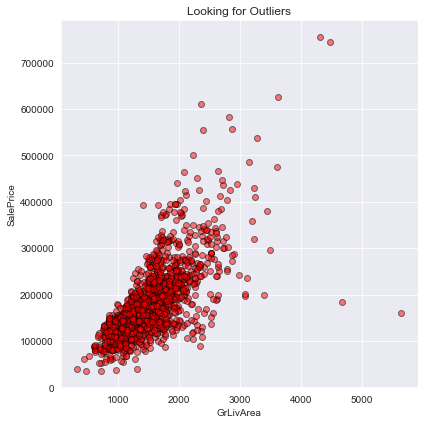

In [5]:
plt.figure(figsize=(6,6))

plt.scatter( train['GrLivArea'], train['SalePrice'] ,c='red', alpha=0.5, edgecolor='black')
plt.xlabel( "GrLivArea" )
plt.ylabel( "SalePrice" )
plt.title("Looking for Outliers")

plt.tight_layout()
plt.show()

In [6]:
train = train.drop( train[(train["GrLivArea"]>4000) & (train["SalePrice"]<300000)].index )

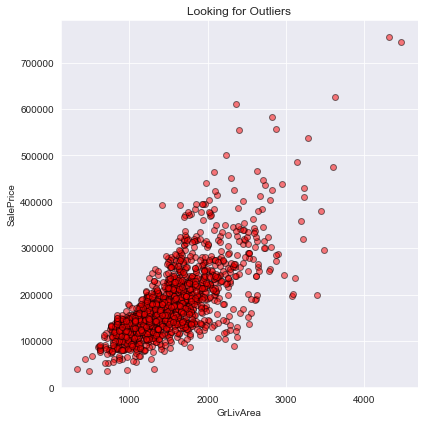

In [7]:
plt.figure(figsize=(6,6))

plt.scatter( train['GrLivArea'], train['SalePrice'] ,c='red', alpha=0.5, edgecolor='black')
plt.xlabel( "GrLivArea" )
plt.ylabel( "SalePrice" )
plt.title("Looking for Outliers")

plt.tight_layout()
plt.show()

Target Variable (SalePrice)


 mu = 180932.92 and sigma = 79467.79



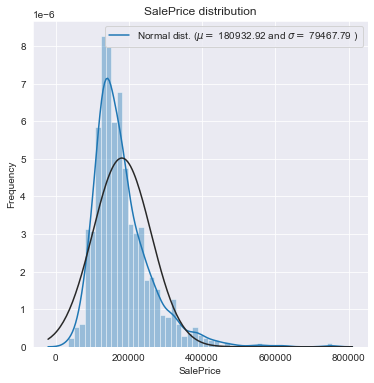

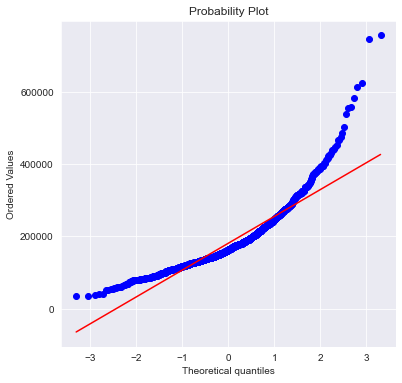

In [8]:
plt.figure(figsize=(6,6))
sns.distplot(train['SalePrice'], fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

plt.figure(figsize=(6,6))

res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



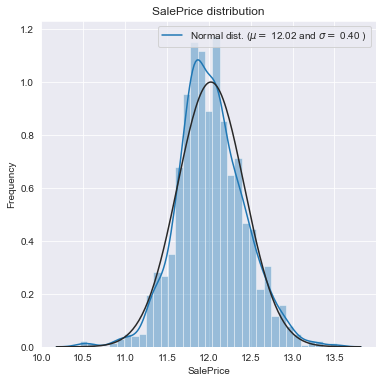

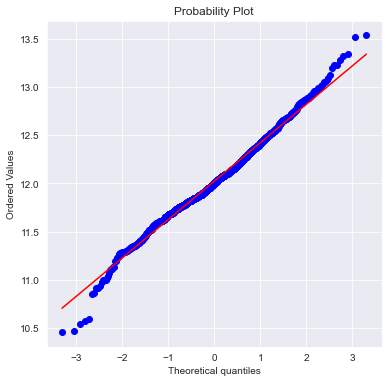

In [9]:
# applying log-transformation on the variable

train['SalePrice'] = np.log1p( train['SalePrice'] )
plt.figure(figsize=(6,6))
sns.distplot(train['SalePrice'], fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

plt.figure(figsize=(6,6))

res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [10]:
# Transformation istributes our Target var normally

Features Engineering

In [11]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

all_data = pd.concat( (train,test) ).reset_index(drop=True)
all_data.drop( ['SalePrice'], axis=1, inplace=True )
print(all_data.shape)

(2917, 79)


Missing Values

In [12]:
all_data_na = (all_data.isnull().sum() / len(all_data))*100
all_data_na = all_data_na.drop( all_data_na[ all_data_na==0 ].index ).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame( {"Missing Ratio":all_data_na} )
missing_data.head(30)

Missing Ratio
PoolQC               99.691
MiscFeature          96.400
Alley                93.212
Fence                80.425
FireplaceQu          48.680
LotFrontage          16.661
GarageFinish          5.451
GarageYrBlt           5.451
GarageQual            5.451
GarageCond            5.451
GarageType            5.382
BsmtExposure          2.811
BsmtCond              2.811
BsmtQual              2.777
BsmtFinType2          2.743
BsmtFinType1          2.708
MasVnrType            0.823
MasVnrArea            0.788
MSZoning              0.137
BsmtFullBath          0.069
BsmtHalfBath          0.069
Utilities             0.069
Functional            0.069
Exterior2nd           0.034
Exterior1st           0.034
SaleType              0.034
BsmtFinSF1            0.034
BsmtFinSF2            0.034
BsmtUnfSF             0.034
Electrical            0.034

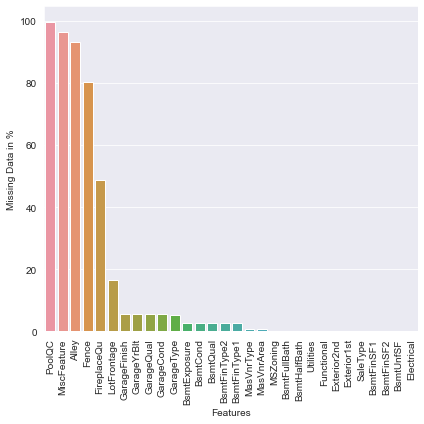

In [13]:
plt.figure(figsize=(6,6))
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Missing Data in %')

plt.tight_layout()
plt.show()

Data Correlation Heatmap

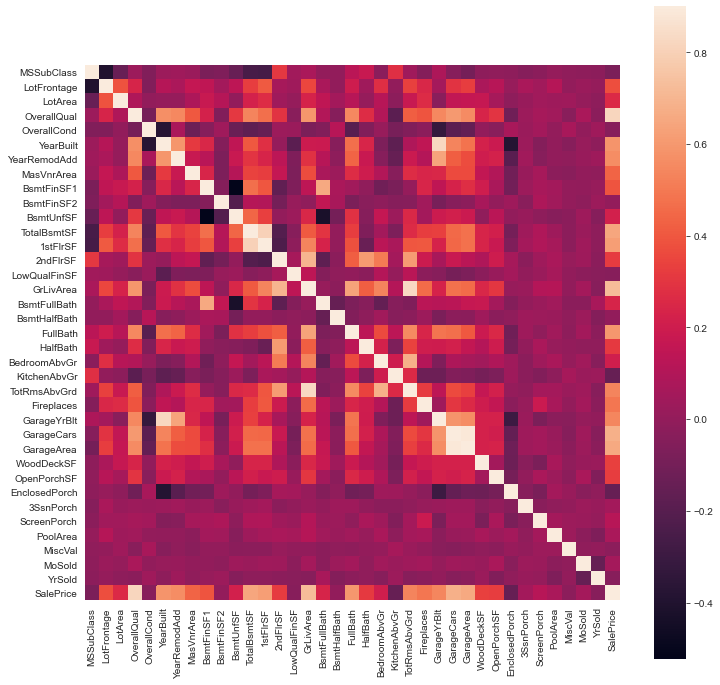

In [14]:
corrmatrix = train.corr()

plt.figure(figsize=(12,12))
sns.heatmap(corrmatrix, vmax = 0.9, square =True)

plt.show()

In [15]:
# look at the heatmap and notedown some intriguing yet obvious correlations

Imputing Missing Values

In [16]:
all_data['PoolQC'] = all_data["PoolQC"].fillna("None")

all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

all_data["Alley"] = all_data["Alley"].fillna("None")

all_data["Fence"] = all_data["Fence"].fillna("None")

all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [17]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform( lambda x : x.fillna(x.median()) )

In [18]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [19]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

Empty DataFrame
Columns: [Missing Ratio]
Index: []

In [20]:
#no missing values

In [21]:
# Transform some numerical vars that are categorical

#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [22]:
#Label Encoding some categorical variables that may 
#contain information in their ordering set
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [23]:
# We add a new feat named TotalSF area since Area feats
#are imp in determining saleprice

# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

Skewed Features

In [24]:
numeric_feats = all_data.dtypes[all_data.dtypes !='object'].index

skewed_feats = all_data[numeric_feats].apply( lambda x:skew(x) ).sort_values(ascending=False)

skewness = pd.DataFrame({ "Skew":skewed_feats })
skewness.head(10)

Skew
MiscVal       21.940
PoolArea      17.689
LotArea       13.109
LowQualFinSF  12.085
3SsnPorch     11.372
LandSlope      4.973
KitchenAbvGr   4.301
BsmtFinSF2     4.145
EnclosedPorch  4.002
ScreenPorch    3.945

In [25]:
# instead of log-transforming the features, we use BoxCox txfmtn

#We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x.
#Note that setting  λ=0  is equivalent to log1p used above for the target variable.


#you can also use PowerTransformer from sklearn.preprocessing
skewness= skewness[abs(skewness)>0.75]

print( "There are {} skewed numerical feats to BoxCox txfm" .format(skewness.shape[0]))

There are 59 skewed numerical feats to BoxCox txfm


In [26]:
from scipy.special import boxcox1p

skewed_features = skewness.index
lmbda = 0.15
for feat in skewed_features:
    all_data[feat]= boxcox1p( all_data[feat],lmbda )

Getting dummy categorical feats 

In [27]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


Splitting back into train and test sets

In [28]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modelling

In [29]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [30]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold( n_folds, shuffle=True, random_state=0 ).get_n_splits(train.values)
    rmse = np.sqrt( -cross_val_score(model,train.values, y_train, scoring= 'neg_mean_squared_error', cv =kf) )
    return (rmse)


Base Models

In [31]:
#This model may be very sensitive to outliers. 
#So we need to made it more robust on them. 
#For that we use the sklearn's Robustscaler() method on pipeline
#Lasso Regression

lasso = make_pipeline( RobustScaler(), Lasso(alpha=0.0005, random_state=1) )

In [32]:
# ElasticNet 
#made robust to outliers

ENet = make_pipeline( RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=0) )

In [33]:
#Kernel Ridge Regression

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [34]:
# Gradient Boosting Regression
# With huber loss that makes it robust to outliers

GBoost = GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,
                                  max_depth=4, max_features = 'sqrt',
                                   min_samples_split=10, loss='huber',
                                   random_state=0
                                  )

In [35]:
# XGBoost

model_xgb = xgb.XGBRegressor( colsample_bytree=0.4603, gamma=0.0468,
                            learning_rate=0.05, max_depth=3,
                            min_child_weight=1.7817, n_estimators=2200,
                            reg_alpha=0.4640, reg_lambda=0.8571,
                            subsample=0.5213, silent=1, 
                            random_state=0, nthread=-1)

In [36]:
#LightGBM

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


Base Model Scores

In [37]:
score = rmsle_cv(lasso)

print( "Lasso Scores (Mean and Std): {:.4f} {:.4f}".format(score.mean(),score.std()) )

Lasso Scores (Mean and Std): 0.1115 0.0074


In [38]:
score = rmsle_cv(ENet)

print( "ElasticNet Scores (Mean and Std): {:.4f} {:.4f}".format(score.mean(),score.std()) )

ElasticNet Scores (Mean and Std): 0.1116 0.0074


In [39]:
score = rmsle_cv(KRR)

print( "KernelRidgeRegression Scores (Mean and Std): {:.4f} {:.4f}".format(score.mean(),score.std()) )

KernelRidgeRegression Scores (Mean and Std): 0.1153 0.0075


In [40]:
score = rmsle_cv(GBoost)

print( "Gradient Boosting Scores (Mean and Std): {:.4f} {:.4f}".format(score.mean(),score.std()) )

Gradient Boosting Scores (Mean and Std): 0.1146 0.0080


In [41]:
score = rmsle_cv(model_xgb)

print( "XGBoost Scores (Mean and Std): {:.4f} {:.4f}".format(score.mean(),score.std()) )

[16:32:41] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:32:46] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:32:50] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:32:55] WARNING: ..

In [42]:
score = rmsle_cv(model_lgb)

print( "LightGBM Scores (Mean and Std): {:.4f} {:.4f}".format(score.mean(),score.std()) )

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

Stacking Models

In [43]:
#Averaged Base Models Class

In [44]:
class AveragingModels( BaseEstimator, RegressorMixin, TransformerMixin ):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [45]:
averaged_models = AveragingModels( models=(ENet, GBoost, KRR, lasso) )

score = rmsle_cv(averaged_models)
print(" Averaged base models score {:.4f} {:.4f}".format(score.mean(),score.std()))

 Averaged base models score 0.1083 0.0076


Less simple stacking : Adding a meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

The procedure, for the training part, may be described as follows:

Split the total training set into two disjoint sets (here train and .holdout )

Train several base models on the first part (train)

Test these base models on the second part (holdout)

Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of all base models on the test data and used them as meta-features on which, the final prediction is done with the meta-model.

In [46]:
# Stacking averaged Models Class

In [47]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

Stacked Averaged Models Score

In [48]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0074)


In [49]:
#we get a better score by adding a meta learner

We add XGBoost, LightGBM to the StackedRegressor defined prev

In [50]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [51]:
# Stacked Regressor

stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07549160538097634


In [52]:
#XGBoost

model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

[16:39:10] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.07835516704279874


In [53]:
#LightGBM

model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.07169383068991829


In [54]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07326028760614907
